In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from  sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score
import random
import time
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.python.layers.core import Dense
import argparse

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.python.layers.core import Dense
import argparse

In [3]:
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical

# Load the EEG data
def load_data():
    data = []
    labels = []
    for i in range(1, 40):  # Assuming 20 .npz files
        subject_data = np.load(f'sleep edf-20/SC_1 ({i}).npz')
        data.append(subject_data['x'])  # Assuming 'eeg' key holds the data
        labels.append(subject_data['y'])  # Assuming 'labels' key holds the stages
    return np.concatenate(data), np.concatenate(labels)

X, y = load_data()

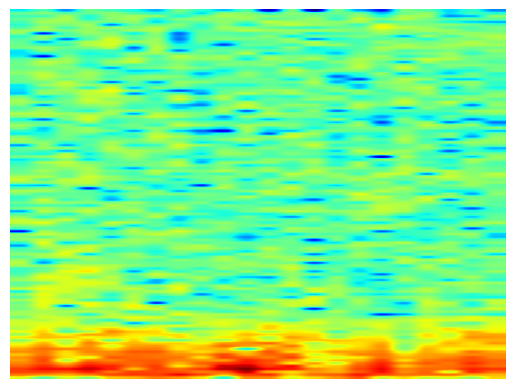

In [4]:
plt.figure()
ax = plt.axes()
ax.set_axis_off()
plt.specgram(X[:,:,0][0], Fs=100, NFFT=256, window=np.hamming(256), noverlap=128, cmap='jet')   #generating spectrogram
plt.show()

IndexError: index 42308 is out of bounds for axis 0 with size 42308

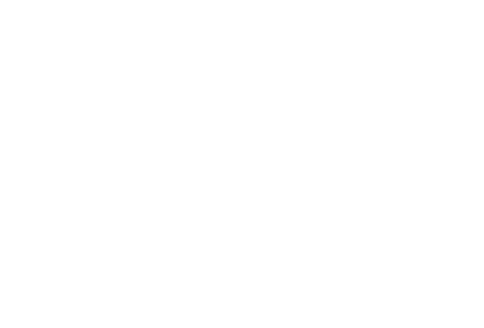

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Assuming X is your data with shape (42308, 3000, 1)

# Create a folder to save the images
output_folder = "spectrogram_images"
os.makedirs(output_folder, exist_ok=True)

# Sampling frequency
Fs = 100
# Parameters for spectrogram
NFFT = 256
noverlap = 128
window = np.hamming(NFFT)

# Loop through each signal and generate/save spectrogram
for i in range(X.shape[0]):
    plt.figure(figsize=(6, 4))
    ax = plt.axes()
    ax.set_axis_off()  # Remove axes

    # Generate spectrogram for the i-th signal (taking the first channel)
    plt.specgram(X[i, :, 0], Fs=Fs, NFFT=NFFT, window=window, noverlap=noverlap, cmap='jet')

    # Save the image with a sequential filename
    plt.savefig(f"{output_folder}/spectrogram_{i+1}.png", bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to free memory


In [5]:
X.shape[0]

42308

In [6]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [7]:
import tensorflow as tf

def basic_conv(x, out_planes, kernel_size, stride=1, padding='valid', dilation=1, groups=1, relu=True, bn=True, bias=False):
    x = tf.keras.layers.Conv2D(out_planes, kernel_size, strides=stride, padding=padding, dilation_rate=dilation, groups=groups, use_bias=bias)(x)
    if bn:
        x = tf.keras.layers.BatchNormalization(epsilon=1e-5, momentum=0.01)(x)
    if relu:
        x = tf.keras.layers.ReLU()(x)
    return x

def channel_pool(x):
    max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
    avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
    
    return tf.concat([max_pool, avg_pool], axis=-1)

def spatial_gate(x, kernel_size=7):
    x_compress = channel_pool(x)
    x_out = basic_conv(x_compress, 1, kernel_size=kernel_size, padding='same', relu=False)
    scale = tf.sigmoid(x_out)
    return x * scale

def triplet_attention(x, no_spatial=False, kernel_size=7):
    # Horizontal attention
    x_perm1 = tf.transpose(x, perm=[0, 2, 1, 3])
    x_out1 = spatial_gate(x_perm1, kernel_size=kernel_size)
    x_out11 = tf.transpose(x_out1, perm=[0, 2, 1, 3])

    # Vertical attention
    x_perm2 = tf.transpose(x, perm=[0, 3, 2, 1])
    x_out2 = spatial_gate(x_perm2, kernel_size=kernel_size)
    x_out21 = tf.transpose(x_out2, perm=[0, 3, 2, 1])

    if not no_spatial:
        # Spatial attention
        x_out_spatial = spatial_gate(x, kernel_size=kernel_size)
        # Combine all three attentions
        x_out = (1 / 3) * (x_out_spatial + x_out11 + x_out21)
    else:
        # Combine horizontal and vertical attentions
        x_out = (1 / 2) * (x_out11 + x_out21)
    
    return x_out


# Trailing

## Trailing

In [8]:
from tensorflow.keras.layers import Concatenate





    


def merge(Input_Sample,input2_time):
    
    y1=build_effb0(Input_Sample)
    y2=tcn_block(input2_time)
    y3=build_LSTM(input2_time)
    
# A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 7, 7, 1280), (None, 3000, 32), (None, 1024)]
     
    
    concatenated_output = Concatenate(axis=-1)([y1,y2,y3])

    y = Dense(512, activation='leaky_relu')(concatenated_output) 
    y = Dropout(0.5)(y)  # Optional: for regularization
    y = Dense(128, activation='leaky_relu')(y) 
    y =  GlobalAveragePooling1D()(y)
    y = Dense(5, activation='softmax')(y) 

    return y



In [9]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Dropout, Add, Input

def residual_block(x, dilation_rate):
    # First dilated convolution layer
    conv1 = Conv1D(filters=32, kernel_size=3, dilation_rate=dilation_rate, padding='causal',name='dd')(x)
    bn1 = BatchNormalization(name='dd1')(conv1)
    relu1 = ReLU(name='dd2')(bn1)
    dropout1 = Dropout(0.5)(relu1)
    
    # Second dilated convolution layer
    conv2 = Conv1D(filters=32, kernel_size=3, dilation_rate=dilation_rate, padding='causal',name='dd4')(dropout1)
    bn2 = BatchNormalization(name='dd5')(conv2)
    relu2 = ReLU(name='dd6')(bn2)
    dropout2 = Dropout(0.5)(relu2)
    
    # Residual connection
    shortcut = Conv1D(filters=32, kernel_size=1, padding='same',name='dd7')(x)
    shortcut_bn = BatchNormalization(name='dd8')(shortcut)
    
    # Add the shortcut to the final output
    output = Add()([dropout2, shortcut_bn])
    
    return output

def tcn_block(input_shape, num_blocks=4):
    
    
    x = input_shape
    dilation_rates = [2**i for i in range(num_blocks)]
    
    for dilation_rate in dilation_rates:
        out = residual_block(x, dilation_rate)
    
    print(f"shape of tcn {out.shape}")

    return out



In [10]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dropout, Dense, Add, GlobalAveragePooling1D,RepeatVector

from tensorflow.keras.models import Model

def build_LSTM(input_shape):

    # First Bi-Directional LSTM layer with Dropout
    x1 = Bidirectional(LSTM(512, return_sequences=True,name='dd9'))(input_shape)
    x1 = Dropout(0.5)(x1)

    # Second Bi-Directional LSTM layer with Dropout
    x2 = Bidirectional(LSTM(512, return_sequences=True,name='dd10'))(x1)
    x2 = Dropout(0.5)(x2)

    # Add the outputs of both LSTM blocks
    # added = Add()([x1, x2])
    
    # Fully connected linear layer with 1024 units
    #dense = Dense(1024)(added)
    dense = Dense(1024,name='dd12')(x2)

    added_2 = Add()([x1, x2,dense])

    # Global Average Pooling
         # gap = GlobalAveragePooling1D()(added_2) . AT first because of this shape changes from (None, 3000, 1024) to (None,1024)



    # Define the model
   # print(gap.shape)
    print(f"shape of lstm {added_2.shape}")
  #  return gap
    return added_2


In [11]:
def build_effb0(Input_Sample):
    
    
    base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    # x = base_model.output
    x = base_model(Input_Sample)
    print(x.shape)
    print(base_model.input)

    for layer in base_model.layers:
        layer.trainable = False
    
    tri_atten = triplet_attention(x, no_spatial=False,kernel_size=13)
    print(f"shape of triplet{tri_atten.shape}")
    y_tri_atten = GlobalAveragePooling2D(name='dd14')(tri_atten)  # (None, 1280)
    
    ## y1 = Dense(3000, activation='relu')(y_tri_atten)
    y1 = RepeatVector(3000)(y_tri_atten)  # Repeat y1 to (None, 3000, 1280)

    print(f"shape of efficient--b0{x.shape}")


    return y1
    

In [12]:
from keras.layers import Input

input1=Input(shape=(224,224,3))
input2_time=Input(shape=(3000,1))      # Example input shape (sequence_length, feature_dim)
                                 #feature_dim refers to the number of features or input channels in each timestep of a sequence.


In [13]:
Output_ =merge(input1,input2_time)


(None, 7, 7, 1280)
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
shape of triplet(None, 7, 7, 1280)
shape of efficient--b0(None, 7, 7, 1280)
shape of tcn (None, 3000, 32)
shape of lstm (None, 3000, 1024)


In [14]:
Model_Enhancer = Model(inputs=[input1,input2_time], outputs=Output_)

In [15]:
import cv2 as cv  # main resean 

def PreProcessData(ImagePath):
    X_=[]
    count=0
    for imageDir in os.listdir(ImagePath):
        if count < 5060 :
            try:
                count=count+1
                img = cv.imread(ImagePath +'/'+imageDir)

                if img is None:
                    print(f"Failed to read image: {imageDir}")
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                img = cv.resize(img, (224,224,))  # Resize to (224, 224)
#cv.resize() function only needs the height and width (i.e., (224, 224)), while the third dimension, representing color channels, is preserved during the resizing operation.
                X_.append(img)
            except:
                print('okk')
    X_ = np.array(X_)

    return X_

In [16]:
import keras
Model_Enhancer.compile(optimizer='adam', loss=keras.losses.CategoricalFocalCrossentropy(alpha=0.25,gamma=2.0,label_smoothing=0.1), metrics=['accuracy'])
Model_Enhancer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 efficientnetb0 (Functional  (None, 7, 7, 1280)           4049571   ['input_1[0][0]']             
 )                                                                                                
                                                                                                  
 tf.compat.v1.transpose (TF  (None, 7, 7, 1280)           0         ['efficientnetb0[0][0]']      
 OpLambda)                                                                                        
                                                                                              

 TFOpLambda)                                                                                      
                                                                                                  
 tf.math.multiply_1 (TFOpLa  (None, 1280, 7, 7)           0         ['tf.compat.v1.transpose_2[0][
 mbda)                                                              0]',                          
                                                                     'tf.math.sigmoid_1[0][0]']   
                                                                                                  
 dropout_6 (Dropout)         (None, 3000, 32)             0         ['dd2[0][0]']                 
                                                                                                  
 bidirectional (Bidirection  (None, 3000, 1024)           2105344   ['input_2[0][0]']             
 al)                                                                                              
          

In [17]:
# Load data and labels
X, y = load_data()
input_image= "Spectrogram"
X_image = PreProcessData(input_image)
y = to_categorical(y)  # Convert labels to one-hot encoded format



In [ ]:
# 20-fold cross-validation
kf = KFold(n_splits=20, shuffle=True, random_state=42)

fold_no = 1


for train_index, test_index in kf.split(X_image):
    print(f"Training fold {fold_no}...")

    # Split the data
    X_train, X_test = X[train_index], X[test_index]
    X_eff, X_eff_test=X_image[train_index], X_image[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    print(X_eff.shape)
    print(X_eff_test.shape)
    


    # Create and train the model
    print("start")
    Model_Enhancer.fit(x=[X_eff,X_train],y= y_train, epochs=250, batch_size=32, verbose=1)

    # Evaluate the model
    loss, accuracy = Model_Enhancer.evaluate([X_test,X_eff_test], y_test, verbose=2)

    print(f"Fold {fold_no} - Accuracy: {accuracy:.4f}")

    fold_no += 1

Training fold 1...
(4807, 3000, 1)
(253, 3000, 1)
(4807, 5)
(253, 5)
(4807, 224, 224, 3)
(253, 224, 224, 3)
start
Epoch 1/8


In [18]:
X_image.shape

(5060, 224, 224, 3)

In [20]:
#  except Exception as e:
#                print(f"Error processing image {imageDir}: {str(e)}")

In [19]:
#  I calculate (42308 * 224 * 224 * 3) / 1024 ** 3 = 5.93 GB!

In [21]:
import psutil

# Get total and available memory
mem = psutil.virtual_memory()

# Print total, available, and used memory in GB
print(f"Total memory: {mem.total / (1024 ** 3):.2f} GB")
print(f"Available memory: {mem.available / (1024 ** 3):.2f} GB")
print(f"Used memory: {mem.used / (1024 ** 3):.2f} GB")


Total memory: 15.79 GB
Available memory: 6.97 GB
Used memory: 8.82 GB
